In [1]:
cd"/content/drive/MyDrive/dataforheatstressheatindex"

/content/drive/MyDrive/dataforheatstressheatindex


In [2]:
ls

 heat_index_Ad-Damazin/      heat_index_Kosti.csv
 heat_index_Ad-Damazin.csv   heat_index_Nyala/
 heat_index_Al_Qadarif/      heat_index_Nyala.csv
 heat_index_Al_Qadarif.csv   heat_index_Omdurman/
 heat_index_El_Obeid/        heat_index_Omdurman.csv
 heat_index_El_Obeid.csv     heat_index_Ouadi_Halfa/
 heat_index_Kassala/         heat_index_Ouadi_Halfa.csv
 heat_index_Kassala.csv      heat_index_Singa/
 heat_index_Khartoum/        heat_index_Singa.csv
 heat_index_Khartoum.csv    'Seasonal Variation of Heat Stress Index.png'
 heat_index_Kosti/          'Variation of Heat Stress Index with respect to years.png'


In [3]:
import pandas as pd
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn import preprocessing

In [4]:
def data_exploration(name):

    df = pd.read_csv(name + ".csv")
    #df.columns = ["value"]
    df.columns = ["value"]
    df[['Date', name]] = df['value'].str.extract(r'(\s*\d{4}-\d{2}-\d{2}\s*)\s+([-\d.\s]+)', expand=True)
    df= df.drop("value", axis=1)
    df["Date"] = pd.to_datetime(df['Date'],format='mixed')
    df[name] = df[name].astype(float)

    return df

In [5]:
# Split sequence function
def split_sequence(sequence, n_steps, n_days):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + n_days > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix + n_days]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [ ]:
df = data_exploration('heat_index_Ad-Damazin')
df.head()

,Date,heat_index_Ad-Damazin
0,1985-01-01,29.15077
1,1985-01-02,29.06318
2,1985-01-03,28.93794
3,1985-01-04,29.21610
4,1985-01-05,28.50835


In [ ]:
x, y = split_sequence(df['heat_index_Ad-Damazin'], 90, 28)

In [ ]:
x

array([[29.15077, 29.06318, 28.93794, ..., 30.72367, 31.20455, 31.4889 ],
       [29.06318, 28.93794, 29.2161 , ..., 31.20455, 31.4889 , 31.64948],
       [28.93794, 29.2161 , 28.50835, ..., 31.4889 , 31.64948, 30.91196],
       ...,
       [26.40868, 26.98258, 27.31567, ..., 27.37696, 26.94083, 26.64206],
       [26.98258, 27.31567, 25.68736, ..., 26.94083, 26.64206, 26.98559],
       [27.31567, 25.68736, 25.63898, ..., 26.64206, 26.98559, 27.75666]])

In [ ]:
x.shape

(10840, 90)

In [ ]:
y

array([[31.64948, 30.91196, 30.50066, ..., 30.49988, 30.98222, 30.94062],
       [30.91196, 30.50066, 29.27922, ..., 30.98222, 30.94062, 31.36657],
       [30.50066, 29.27922, 30.80728, ..., 30.94062, 31.36657, 31.89448],
       ...,
       [26.98559, 27.75666, 28.20248, ..., 28.41211, 28.00477, 27.5663 ],
       [27.75666, 28.20248, 28.16049, ..., 28.00477, 27.5663 , 27.38604],
       [28.20248, 28.16049, 27.69984, ..., 27.5663 , 27.38604, 27.37668]])

In [ ]:
y[0]

array([31.64948, 30.91196, 30.50066, 29.27922, 30.80728, 30.6777 ,
       31.27982, 30.30152, 29.83768, 29.18278, 28.16336, 28.4962 ,
       30.76587, 30.68498, 31.1451 , 30.63267, 30.87831, 31.84485,
       32.45809, 32.44304, 31.53808, 30.28629, 29.59952, 29.20697,
       29.87426, 30.49988, 30.98222, 30.94062])

In [ ]:
import numpy as np
np.isnan(x).sum()

0

In [ ]:
import numpy as np
np.isnan(y).sum()

0

In [6]:
def HI_train_with_LSTM(name, n_epochs, n_steps, n_days, directory):
  df = data_exploration(name)
  transformer = preprocessing.MinMaxScaler().fit(df[[name]])
  HI_transformed = transformer.transform(df[[name]])
  #print(f'Min : ',round(HI_transformed.min(),2),', Max :', round(HI_transformed.max(),2))
  #print(f'Mean : ',round(HI_transformed.mean(),2),', Standard Deviation :', round(HI_transformed.std(),2))
  time_start = time.time()


  # Parameters
  # n_steps = 90
  # n_days  = 2

  Sequence = HI_transformed # replace with your actual data

  # Preparing the data
  X, y = split_sequence(Sequence.reshape(len(Sequence), 1), n_steps, n_days)

  #print(X.shape)
  #print(y.shape)

  X = X.reshape((X.shape[0], X.shape[1], 1))

  # Splitting into train, validation, and test sets
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

  # Building the model
  model = Sequential()

  model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
  model.add(LSTM(100, activation='relu'))
  model.add(Dense(n_days))
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Fitting the model
  history = model.fit(X_train, y_train, epochs=n_epochs, validation_data=(X_val, y_val), verbose=2)

  # Predicting
  predicted_HI = model.predict(X_test)

  #print("type(predicted_HI) = ", type(predicted_HI))
  #print("predicted_HI.shape = ", predicted_HI.shape)
  #print("y_test.shape = ", y_test.shape)


  y_test_res = y_test.reshape(y_test.shape[0], y_test.shape[1])
  print("y_test_res.shape = ", y_test_res.shape)
  print("days = ", n_days)

  # Performance metrics
  mape = np.mean(np.abs(predicted_HI.reshape(-1) - y_test)) * 100
  rmse = np.sqrt(mean_squared_error(y_test_res, predicted_HI))
  r2 = r2_score(y_test_res, predicted_HI)
  t_time = time.time() - time_start

  print("RMSE =", rmse)
  print("MAPE =", mape)
  print("R-squared =", r2)
  print("Time taken =", t_time)

  # Plotting train loss and validation loss
  plt.figure(figsize=(12, 6))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(name + ':    Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  #plt.show()
  plt.savefig(directory + '/' + "Training and Validation Loss" + '.png')


  # Plotting predicted vs actual
  plt.figure(figsize=(12, 6))
  plt.plot(y_test_res[:,n_days-1], label='Actual day')
  plt.plot(predicted_HI[:,n_days-1], label='Predicted')
  plt.title(name + "    Day "+str(n_days)+' : Predicted vs Actual')
  plt.xlabel('Samples')
  plt.ylabel('Value')
  plt.legend()
  #plt.show()
  plt.savefig(directory + '/' + "Actual_vs_Predicted" + '.png')

  plt.figure(figsize=(12, 6))
  plt.scatter(y_test_res[:,n_days-1], predicted_HI[:,n_days-1])
  plt.plot(y_test_res[:,n_days-1], y_test_res[:,n_days-1], color = 'red')
  plt.title(name + '    Day '+str(n_days)+' : Predicted vs Actual (scatter)')
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  #plt.show()
  plt.savefig(directory + '/' + "Actual_vs_Predicted (scatter)" + '.png')

  model.save(directory + "/model.keras")
  #loaded_model = keras.saving.load_model("model.keras")
  #sys.exit()
  return mape, rmse, r2, t_time

In [7]:
  import os

  def make_directory(directory):
    if not os.path.exists(directory):
      os.makedirs(directory)
    else:
      print("Directory already exists")

Directory already exists
Directory already exists
Epoch 1/10
238/238 - 35s - loss: 0.0180 - val_loss: 0.0069 - 35s/epoch - 147ms/step
Epoch 2/10
238/238 - 34s - loss: 0.0068 - val_loss: 0.0062 - 34s/epoch - 142ms/step
Epoch 3/10
238/238 - 34s - loss: 0.0059 - val_loss: 0.0049 - 34s/epoch - 145ms/step
Epoch 4/10
238/238 - 35s - loss: 0.0039 - val_loss: 0.0025 - 35s/epoch - 147ms/step
Epoch 5/10
238/238 - 36s - loss: 0.0026 - val_loss: 0.0024 - 36s/epoch - 150ms/step
Epoch 6/10
238/238 - 36s - loss: 0.0024 - val_loss: 0.0026 - 36s/epoch - 153ms/step
Epoch 7/10
238/238 - 34s - loss: 0.0023 - val_loss: 0.0021 - 34s/epoch - 142ms/step
Epoch 8/10
238/238 - 34s - loss: 0.0023 - val_loss: 0.0020 - 34s/epoch - 141ms/step
Epoch 9/10
238/238 - 33s - loss: 0.0022 - val_loss: 0.0020 - 33s/epoch - 140ms/step
Epoch 10/10
238/238 - 34s - loss: 0.0022 - val_loss: 0.0025 - 34s/epoch - 141ms/step
51/51 [==============================] - 3s 57ms/step
y_test_res.shape =  (1631, 1)
days =  1
RMSE = 0.050225

<ipython-input-6-deaa809bfe09>:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


Epoch 1/10
238/238 - 35s - loss: 1.1627 - val_loss: 0.0108 - 35s/epoch - 147ms/step
Epoch 2/10
238/238 - 34s - loss: 0.0103 - val_loss: 0.0113 - 34s/epoch - 144ms/step
Epoch 3/10
238/238 - 32s - loss: 0.0097 - val_loss: 0.0093 - 32s/epoch - 135ms/step
Epoch 4/10
238/238 - 33s - loss: 0.0093 - val_loss: 0.0088 - 33s/epoch - 137ms/step
Epoch 5/10
238/238 - 33s - loss: 0.0091 - val_loss: 0.0093 - 33s/epoch - 138ms/step
Epoch 6/10
238/238 - 32s - loss: 0.0090 - val_loss: 0.0087 - 32s/epoch - 134ms/step
Epoch 7/10
238/238 - 32s - loss: 0.0088 - val_loss: 0.0085 - 32s/epoch - 135ms/step
Epoch 8/10
238/238 - 32s - loss: 0.0086 - val_loss: 0.0082 - 32s/epoch - 135ms/step
Epoch 9/10
238/238 - 34s - loss: 0.0085 - val_loss: 0.0089 - 34s/epoch - 144ms/step
Epoch 10/10
238/238 - 32s - loss: 0.0085 - val_loss: 0.0081 - 32s/epoch - 135ms/step
51/51 [==============================] - 3s 51ms/step
y_test_res.shape =  (1629, 14)
days =  14
RMSE = 0.09277932042895043
MAPE = 19.525375393811515
R-squared 

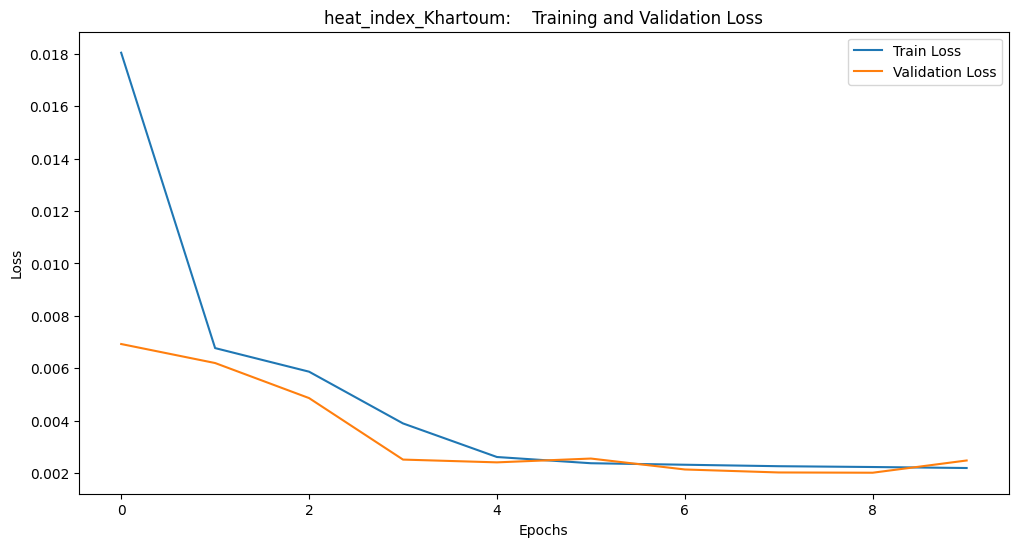

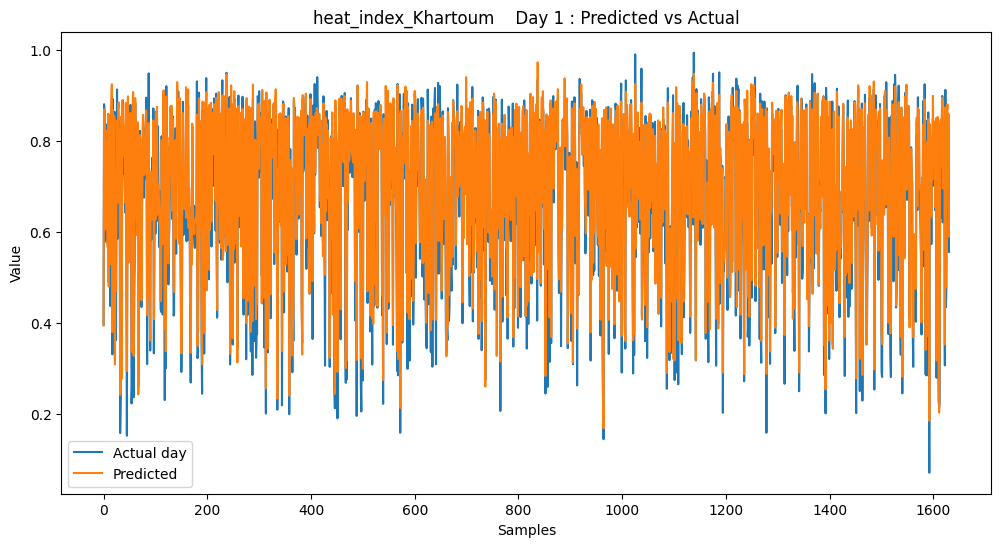

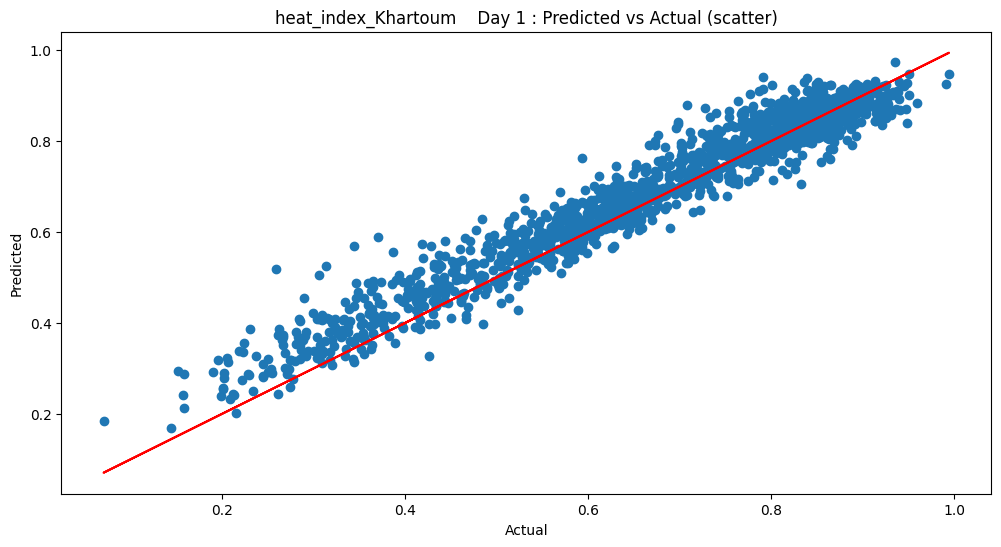

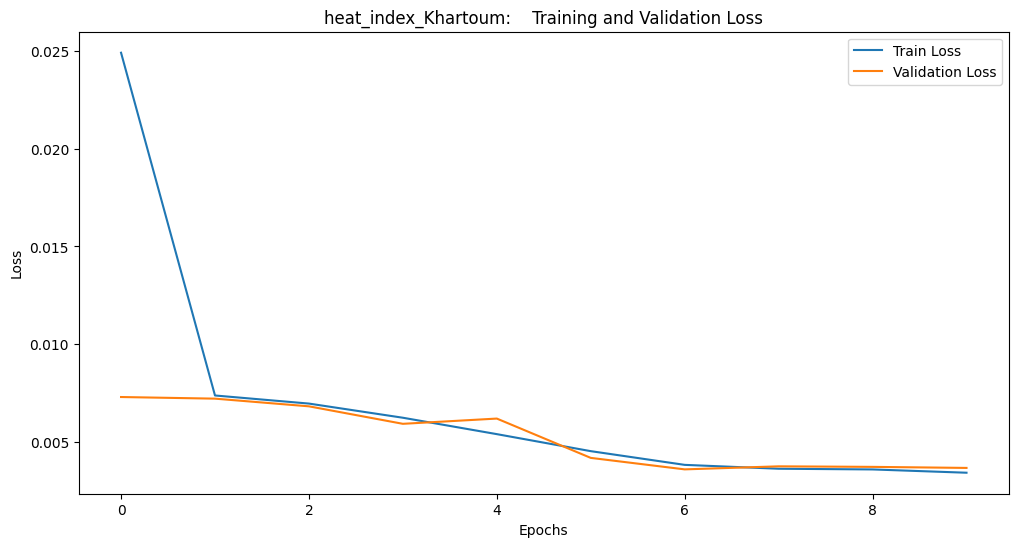

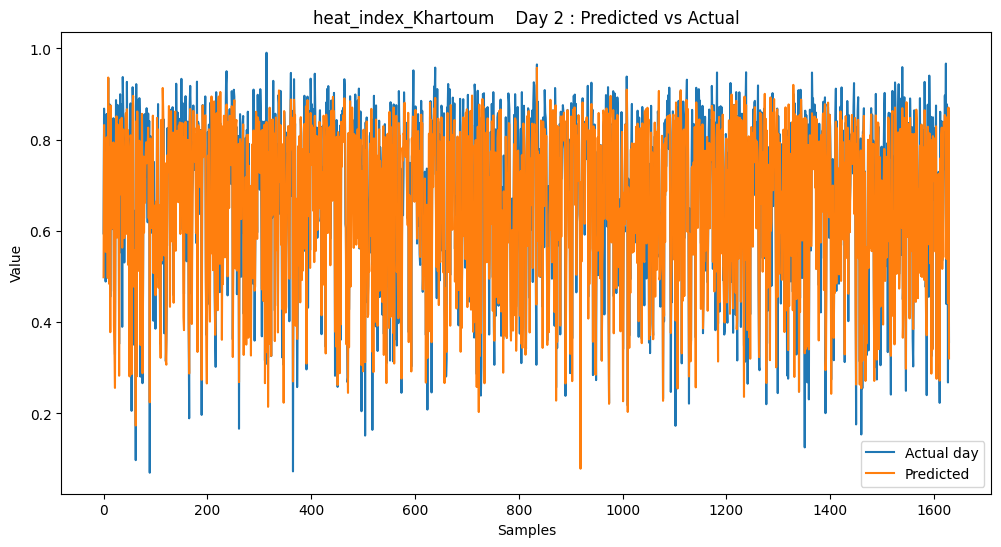

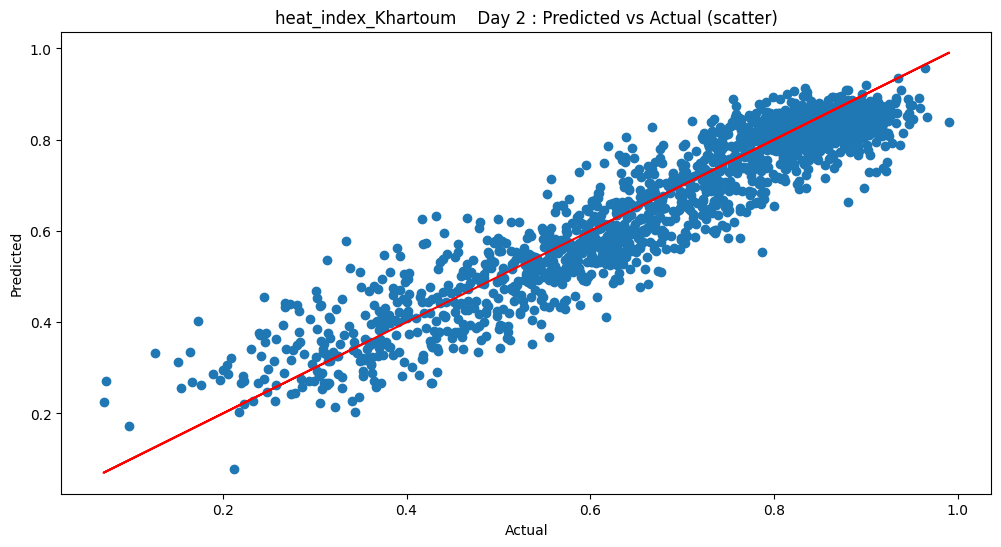

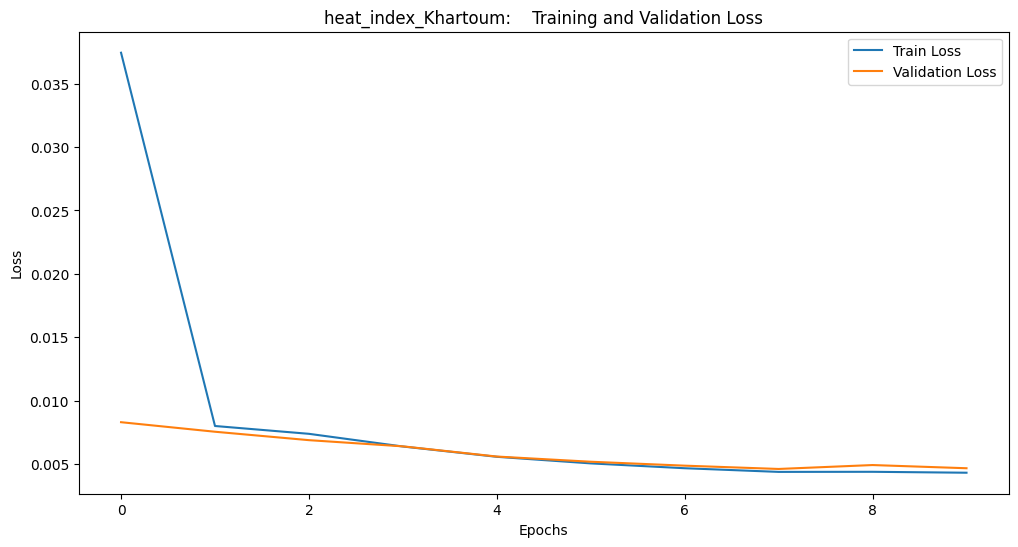

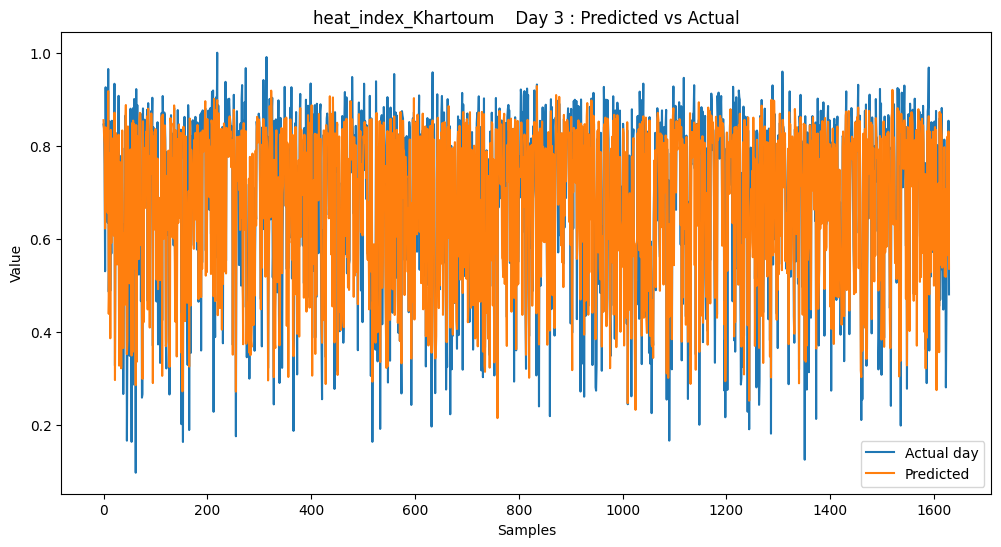

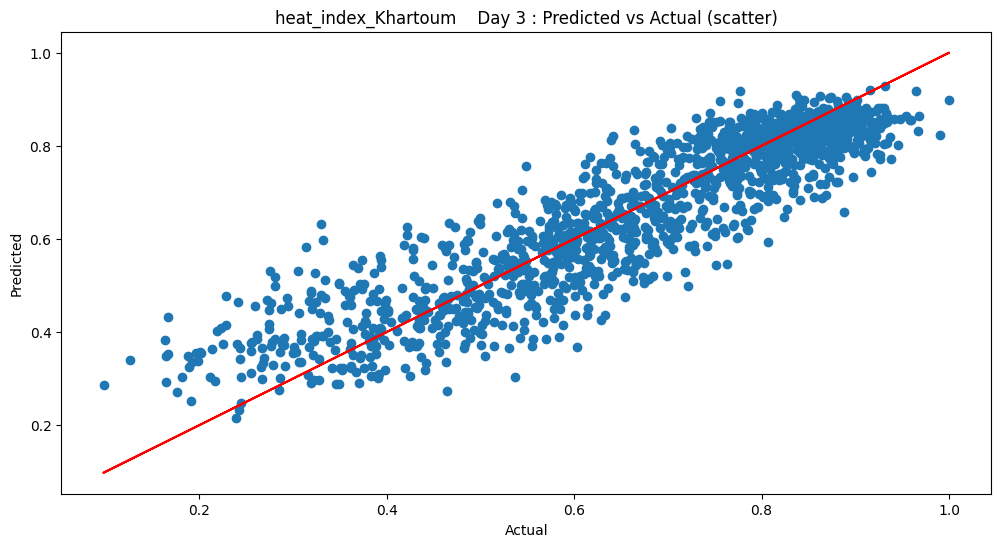

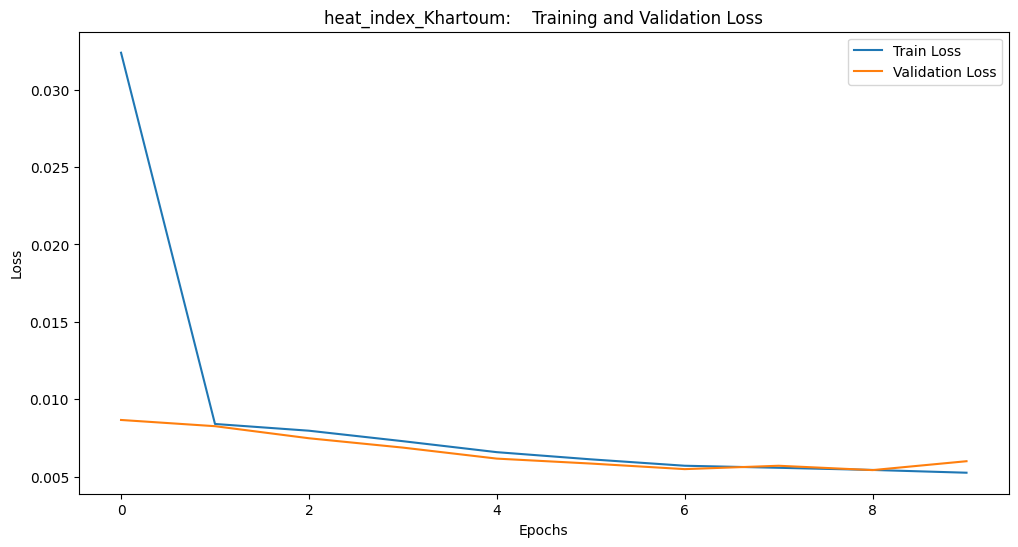

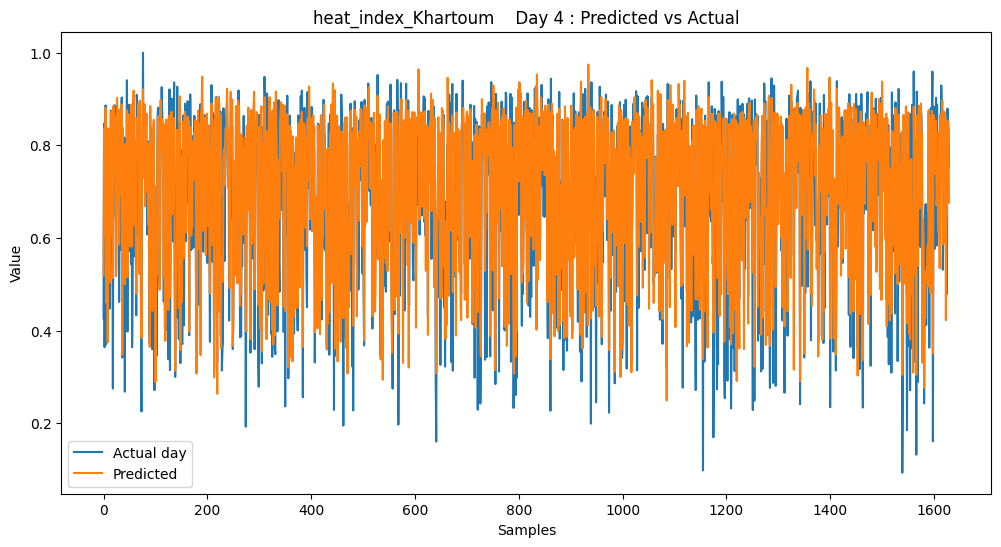

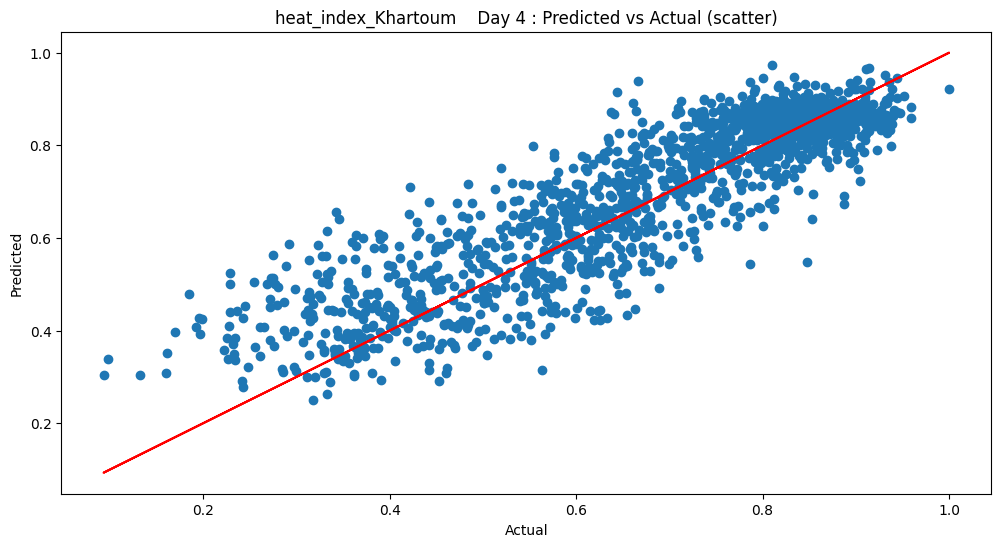

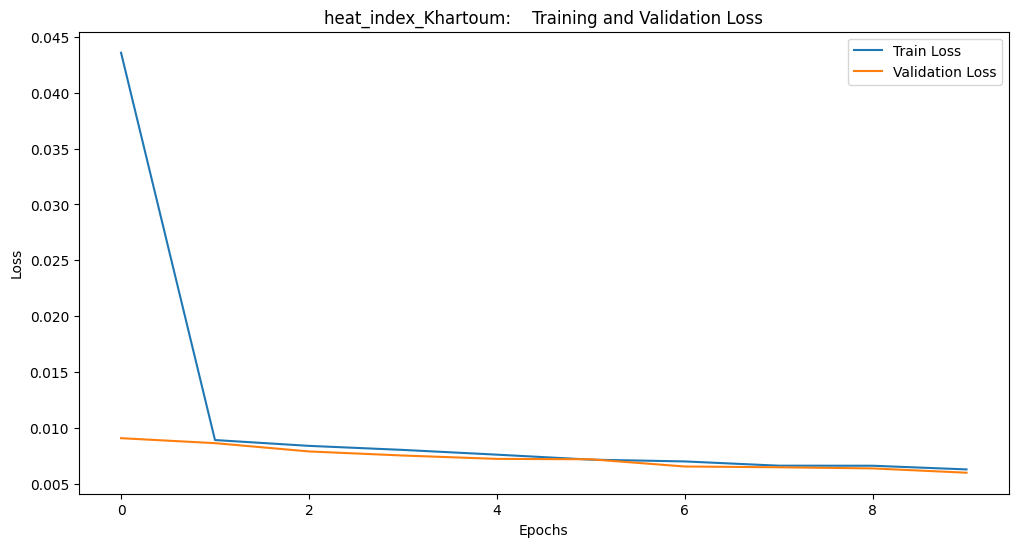

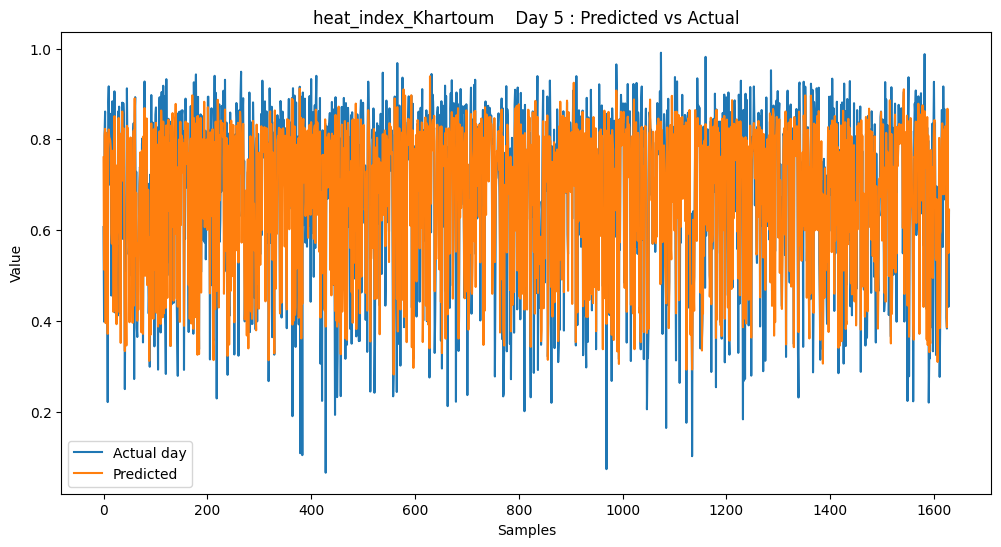

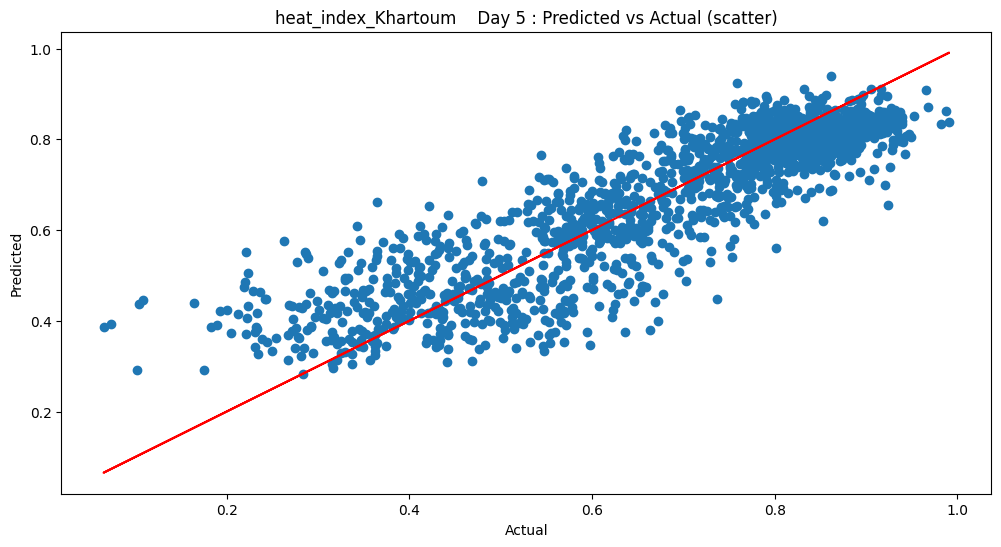

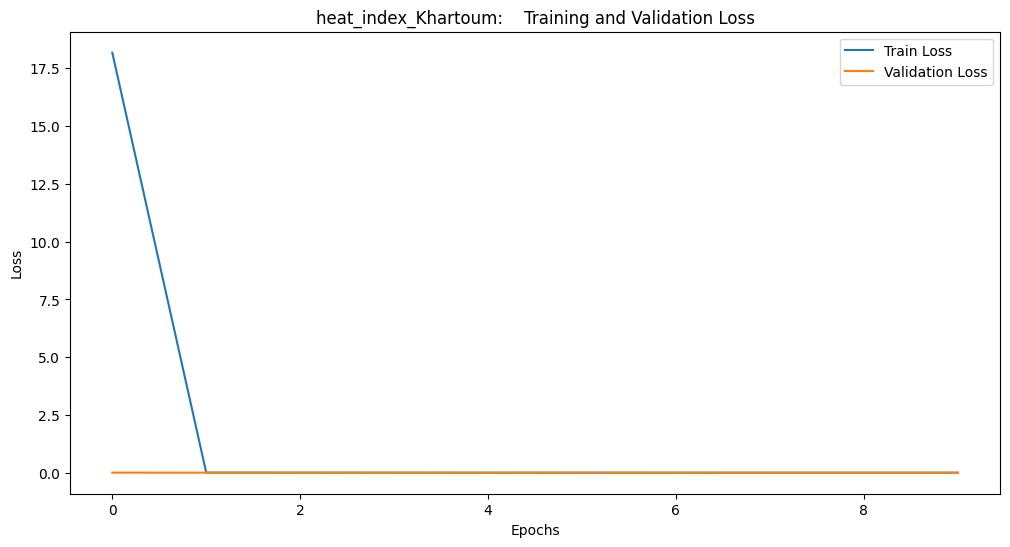

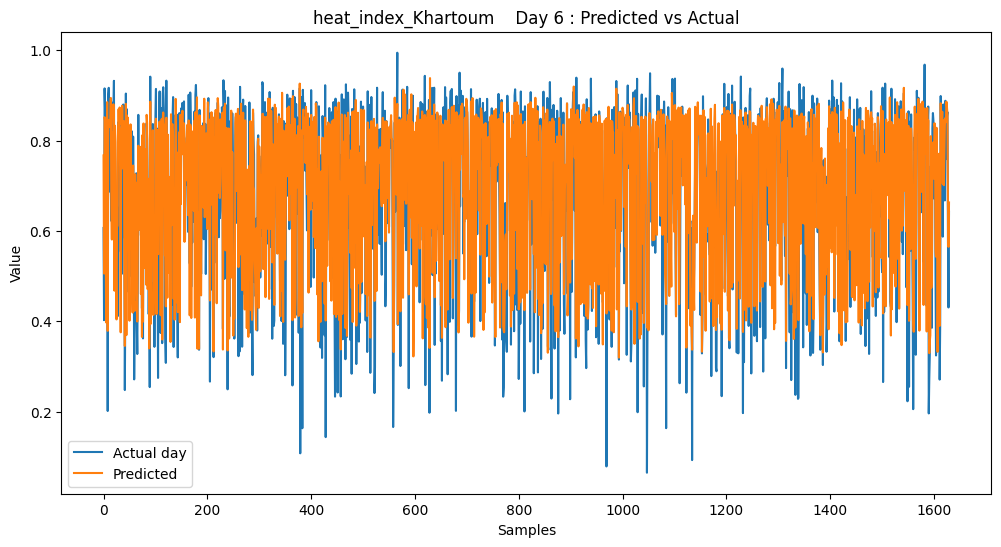

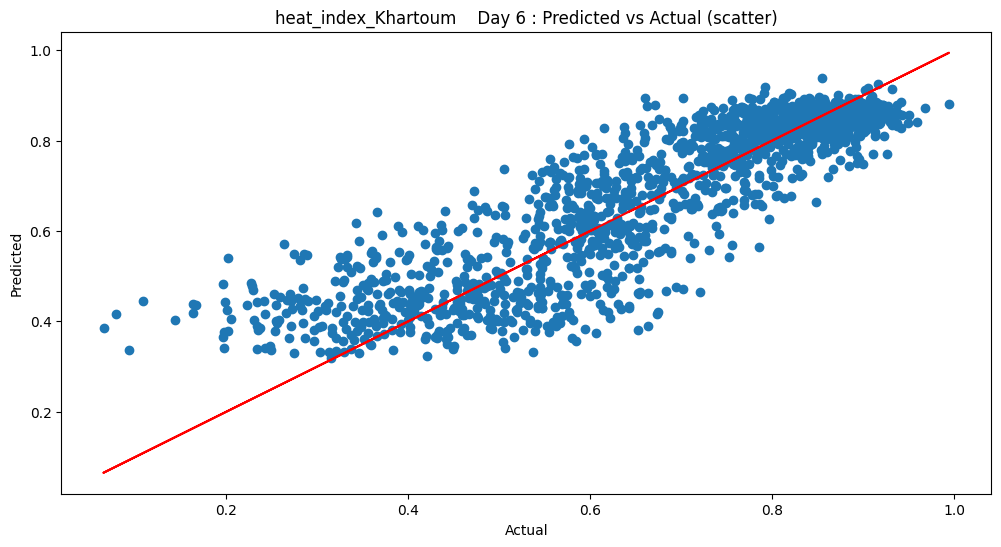

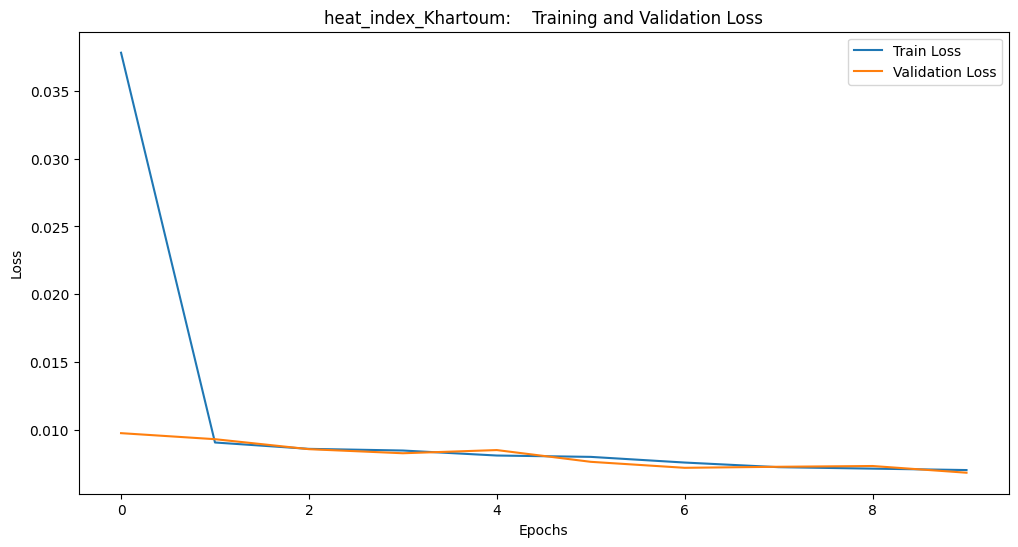

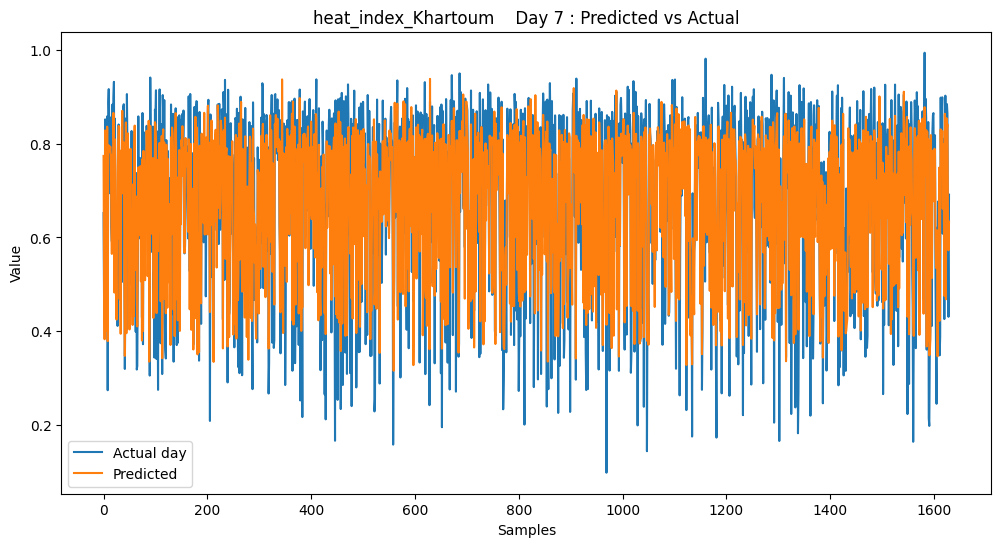

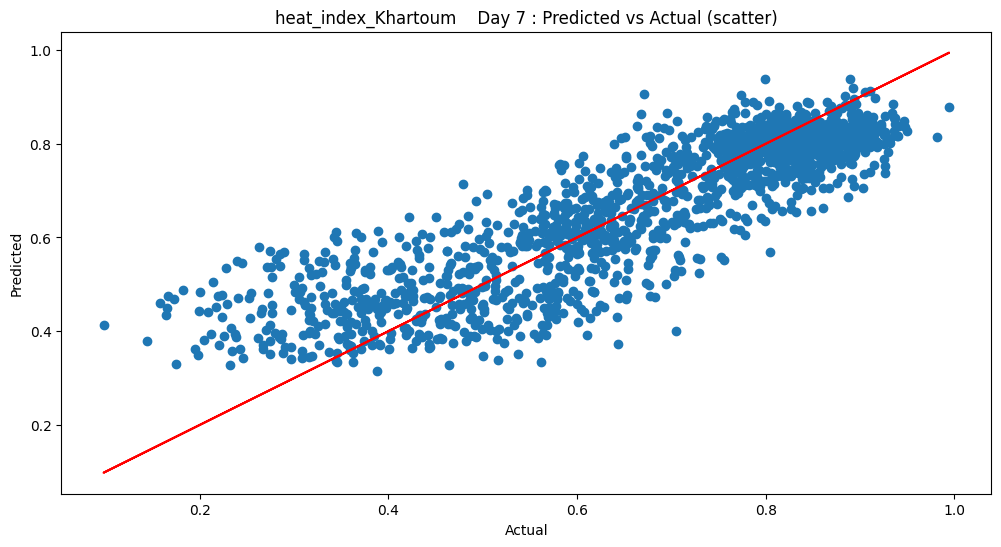

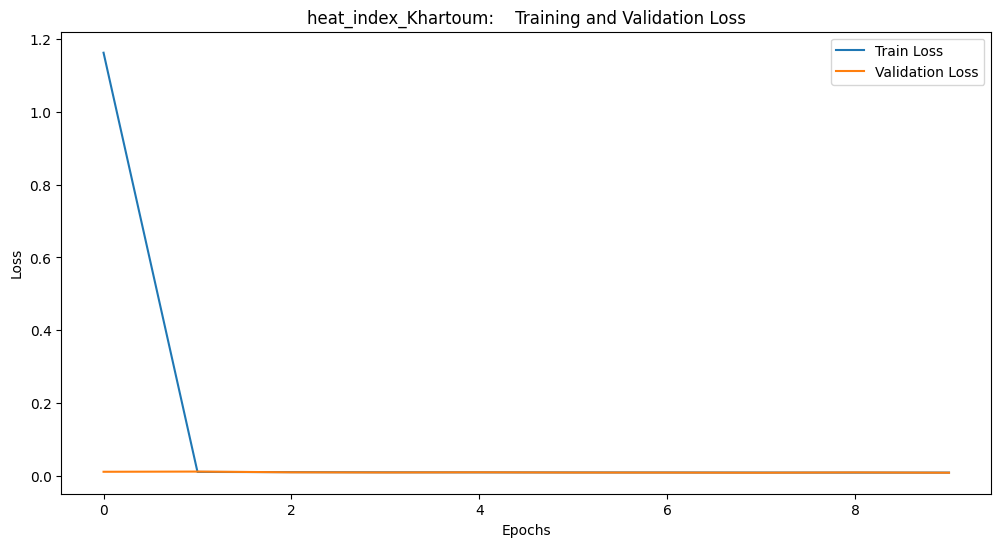

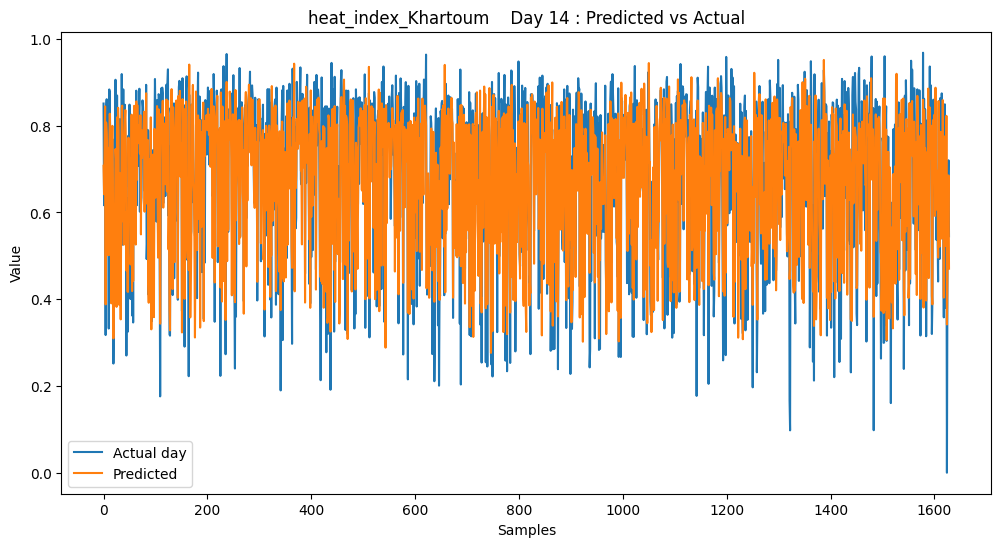

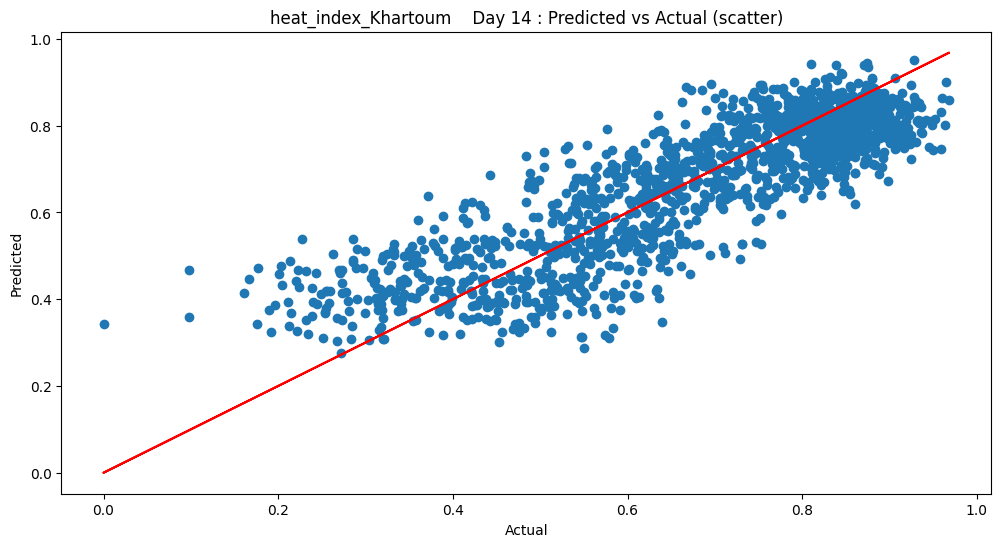

In [8]:
n_epochs = 10
n_steps = 90

SITES_NAMES = ['heat_index_Khartoum']


# N_DAYS = [1, 2]
N_DAYS = [1, 2, 3, 4, 5, 6, 7, 14]

for name in SITES_NAMES:
  directory1 = f"./{name}"
  make_directory(directory1)

  metrics_df = dict()

  metrics_df['RMSE'] = list()
  metrics_df['MAPE'] = list()
  metrics_df['R-squared'] = list()
  metrics_df['Time taken'] = list()
  metrics_df['n_days'] = list()

  for n_day in N_DAYS:
    directory2 = f"{directory1}/days_{n_day}"
    make_directory(directory2)

    mape, rmse, r2, t_time = HI_train_with_LSTM(name, n_epochs, n_steps, n_day, directory2)

    metrics_df['RMSE'].append(rmse)
    metrics_df['MAPE'].append(mape)
    metrics_df['R-squared'].append(r2)
    metrics_df['Time taken'].append(t_time)
    metrics_df['n_days'].append(n_day)

  metrics_df = pd.DataFrame(metrics_df)
  metrics_df.to_csv(f"{directory1}/metrics.csv", index=False)